In [1]:
import pandas as pd
import numpy as np
import io
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import IPython.display
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from serenityff.charge.tree.dash_tree import DASHTree
from rdkit.Chem.Draw.IPythonConsole import drawMol3D
from rdkit.Chem.MolStandardize import rdMolStandardize
import pickle
from rdkit.Chem import rdDetermineBonds
import glob

In [2]:
plt.rcParams.update({'font.size': 16})

In [86]:
def dash_corr_plot(df, x, y, fig, ax, xy_range, xlabel=None, ylabel=None, vmin=0.1, vmax=100, text=None, err_range=(-0.5,0.5), stats=False, inset_loc=[0.69 , 0.06, 0.3, 0.3], draw_inset_0_vline=False, insert_yticks=[], unit_stats="", cbar_ax_loc=[0.91, 0.15, 0.05, 0.7]):
    df_plot = df[[x,y]].dropna()
    h1 = ax.hist2d(df_plot[x], df_plot[y], bins=100, cmap="Greens", norm=LogNorm(vmin=vmin, vmax=vmax), range=(xy_range, xy_range))
    if xlabel is None:
        xlabel = x
    if ylabel is None:
        ylabel = y
    ax.set_xlabel(f"{xlabel}")
    ax.set_ylabel(f"{ylabel}")
    ax.plot(xy_range, xy_range, color='grey', linestyle=':')
    if text is not None:
        ax.text(0.05, 0.95, text, transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top')
    if stats:
        mae = np.mean(np.abs(df_plot[x]-df_plot[y]))
        rmse = np.sqrt(np.mean((df_plot[x]-df_plot[y])**2))
        r2 = np.corrcoef(df_plot[x], df_plot[y])[0,1]**2
        tau = df_plot[[x,y]].corr(method="kendall").iloc[0,1]
        ax.text(0.05, 0.85, f"MAE: {mae:.3f}{unit_stats}\nRMSE: {rmse:.3f}{unit_stats}\nR2: {r2:.3f}\nTau: {tau:.3f}", transform=ax.transAxes,
        fontsize=12, va='top')
    ax_ins = ax.inset_axes(inset_loc, frameon=True)
    err = df_plot[x]-df_plot[y]
    ax_ins.hist(err, bins=100, color="C2", range=err_range)
    ax_ins.set_xlabel(f"error", fontsize=11)
    ax_ins.tick_params(axis='both', which='major', labelsize=11)
    ax_ins.xaxis.set_label_position("top")
    if insert_yticks:
        ax_ins.set_yticks(insert_yticks)
        # scientific notation for yticklabels
        ax_ins.yaxis.set_major_formatter(plt.matplotlib.ticker.ScalarFormatter(useMathText=True))
        ax_ins.set_ylim(0, np.max(insert_yticks))
    else:
        ax_ins.yaxis.set_ticklabels([])
        ax_ins.set_yticks([])
    if draw_inset_0_vline:
        ax_ins.axvline(0, color='black', linestyle='--', linewidth=0.6)
    #ax_ins.set_xticks([-0.5,0,0.5], fontsize=11, labels=["-0.5","0","0.5"])
    #ax_ins.set_ylabel(f"Count", fontsize=11)
    #ax_ins.set_ylim([0,2e6])
    #ax_ins.set_yticks([0,5e6], fontsize=11, labels=["0","5"])
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes(cbar_ax_loc)
    cbar = fig.colorbar(h1[3], cax=cbar_ax)
    cbar.ax.set_ylabel('Counts', rotation=270, labelpad=15, fontsize=14)

In [4]:
folder_path = "/localhome/mlehner/props/test190_vehicle/"
sdf_file = f"{folder_path}sdf_VEHICLe_collect.sdf"
df_file = f"{folder_path}props_all.h5"

In [5]:
mol_sup = Chem.SDMolSupplier(sdf_file, removeHs=False)

In [6]:
tmol = mol_sup[0]

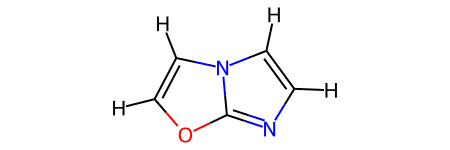

In [7]:
tmol

In [8]:
df = pd.read_hdf(df_file)

In [9]:
df.head()

,mol_idx,atom_idx,element,mulliken,resp1,resp2,dual,homo,lumo,cnf_idx,mbis_dipole_strength,mbis_dipole_x,mbis_dipole_y,mbis_dipole_z,mol_dipole,DASH_IDX,DASH_SDF_IDX,MBIScharge
0,2,0,C,-0.095700,0.087942,0.087942,NaN,-0.214152,-0.009668,0,0.134630,-0.028417,-0.131578,-0.002210,2.215106,VEHICLe_2,0,0.0004
1,2,1,C,-0.209423,-0.737014,-0.737014,NaN,-0.214152,-0.009668,0,0.124728,-0.122855,0.021532,0.000065,2.215106,VEHICLe_2,0,-0.2260
2,2,2,N,0.094506,0.679593,0.679593,NaN,-0.214152,-0.009668,0,0.124326,-0.003831,0.124250,0.002033,2.215106,VEHICLe_2,0,-0.0806
3,2,3,C,-0.176004,-0.537220,-0.537220,NaN,-0.214152,-0.009668,0,0.138807,0.123801,0.062760,0.001330,2.215106,VEHICLe_2,0,-0.1494
4,2,4,C,-0.015761,-0.100107,-0.100107,NaN,-0.214152,-0.009668,0,0.165356,0.065093,-0.151988,-0.002295,2.215106,VEHICLe_2,0,-0.0397


In [10]:
tree_path = "/home/mlehner/serenityff-charge/serenityff/charge/data/dashProps/"
tree = DASHTree(tree_folder_path=tree_path)

Loading DASH tree data
Loaded 122 trees and data


In [11]:
tree.data_storage[0].keys()

Index(['level', 'atom_type', 'con_atom', 'con_type', 'result', 'std',
       'max_attention', 'size', 'mulliken', 'resp1', 'resp2', 'dual',
       'mbis_dipole_strength', 'dipole_bond_1', 'dipole_bond_2',
       'dipole_bond_3', 'AM1BCC', 'AM1BCC_std', 'DFTD4:C6', 'DFTD4:C6_std',
       'DFTD4:polarizability', 'DFTD4:polarizability_std'],
      dtype='object')

In [12]:
re_mulliken_mol0 = tree.get_molecules_partial_charges(mol_sup[0], chg_key="mulliken", chg_std_key="std")

In [13]:
re_mulliken_mol0.keys()

dict_keys(['charges', 'std', 'match_depth'])

In [14]:
mbis_data = []
mulliken_data = []
resp1_data = []
resp2_data = []
mbis_dipole_strength_data = []
dipole_bond_1_data = []
mol_data = []
if True:
    for mol_index, mol in tqdm(enumerate(mol_sup), total=len(mol_sup)):
        nodePathList = nodePathList = tree._get_allAtoms_nodePaths(mol=mol)
        mbis = tree.get_molecules_partial_charges(mol, chg_key="result", chg_std_key="std", nodePathList=nodePathList)["charges"]
        mulliken = tree.get_molecules_partial_charges(mol, chg_key="mulliken", chg_std_key="std", nodePathList=nodePathList)["charges"]
        resp1 = tree.get_molecules_partial_charges(mol, chg_key="resp1", chg_std_key="std", nodePathList=nodePathList)["charges"]
        resp2 = tree.get_molecules_partial_charges(mol, chg_key="resp2", chg_std_key="std", nodePathList=nodePathList)["charges"]
        mbis_dipole_strength = []
        dipole_bond_1 = []
        atom_indices = []
        for atom_idx in range(mol.GetNumAtoms()):
            atom_indices.append(atom_idx)
            nodePath = nodePathList[atom_idx]
            mbis_dipole_strength.append(tree.get_property_noNAN(matched_node_path=nodePath, property_name="mbis_dipole_strength"))
            dipole_bond_1.append(tree.get_property_noNAN(matched_node_path=nodePath, property_name="dipole_bond_1"))
        mol_idx_per_atom = [mol_index]*len(atom_indices)
        #mini_df = pd.DataFrame({"mol_idx": mol_idx_per_atom, "atom_idx": atom_indices, "mbis":mbis, "mulliken": mulliken, "resp1": resp1, "resp2": resp2, "mbis_dipole_strength": mbis_dipole_strength, "dipole_bond_1": dipole_bond_1})
        #pred_data.append(mini_df)
        mbis_data.extend(mbis)
        mulliken_data.extend(mulliken)
        resp1_data.extend(resp1)
        resp2_data.extend(resp2)
        mbis_dipole_strength_data.extend(mbis_dipole_strength)
        dipole_bond_1_data.extend(dipole_bond_1)
        
        # mol props
        mol_dipole_no_atomic = tree.get_molecular_dipole_moment(mol, chg_std_key="std", add_atomic_dipoles=False, nodePathList=nodePathList)
        mol_dipole_with_atomic = tree.get_molecular_dipole_moment(mol, chg_std_key="std", add_atomic_dipoles=True, nodePathList=nodePathList)
        mol_data.append([mol_dipole_no_atomic, mol_dipole_with_atomic])

100%|██████████| 73391/73391 [51:40<00:00, 23.67it/s]


In [15]:
df["mbis_pred"] = mbis_data
df["mulliken_pred"] = mulliken_data
df["resp1_pred"] = resp1_data
df["resp2_pred"] = resp2_data
df["mbis_dipole_strength_pred"] = mbis_dipole_strength_data
df["dipole_bond_1_pred"] = dipole_bond_1_data

In [16]:
def get_mol_dipole_from_df_grouped_lines(df_lines):
    mol_sup_idx = df_lines["DASH_SDF_IDX2"].iloc[0]
    mol = mol_sup[int(mol_sup_idx)]
    vec_sum = np.zeros(3)
    atom_indices = df_lines["atom_idx"].values
    atom_charges = df_lines["MBIScharge"].values
    mbis_dipole_x = df_lines["mbis_dipole_x"].values
    mbis_dipole_y = df_lines["mbis_dipole_y"].values
    mbis_dipole_z = df_lines["mbis_dipole_z"].values
    mbis_dipoles = np.array([mbis_dipole_x, mbis_dipole_y, mbis_dipole_z]).T
    for ai, chg in zip(atom_indices, atom_charges):
        vec_sum += chg * np.array(mol.GetConformer().GetAtomPosition(int(ai)))
    for mbis_dipole in mbis_dipoles:
        vec_sum += mbis_dipole
    return np.linalg.norm(vec_sum)

In [17]:
df["DASH_SDF_IDX2"] = df["DASH_SDF_IDX"]

In [18]:
tqdm.pandas()

In [19]:
df_mbis_ref_dipole = df.groupby("DASH_SDF_IDX").progress_apply(get_mol_dipole_from_df_grouped_lines)

  0%|          | 0/73391 [00:00<?, ?it/s]

100%|██████████| 73391/73391 [03:30<00:00, 348.91it/s]


In [20]:
df.to_csv("test_301_atomData_new.csv")

In [65]:
df = pd.read_csv("test_301_atomData_new.csv")

In [22]:
df.keys()

Index(['Unnamed: 0', 'mol_idx', 'atom_idx', 'element', 'mulliken', 'resp1',
       'resp2', 'dual', 'homo', 'lumo', 'cnf_idx', 'mbis_dipole_strength',
       'mbis_dipole_x', 'mbis_dipole_y', 'mbis_dipole_z', 'mol_dipole',
       'DASH_IDX', 'DASH_SDF_IDX', 'MBIScharge', 'mbis_pred', 'mulliken_pred',
       'resp1_pred', 'resp2_pred', 'mbis_dipole_strength_pred',
       'dipole_bond_1_pred', 'DASH_SDF_IDX2'],
      dtype='object')

In [23]:
df

,Unnamed: 0,mol_idx,atom_idx,element,mulliken,resp1,resp2,dual,homo,lumo,...,DASH_IDX,DASH_SDF_IDX,MBIScharge,mbis_pred,mulliken_pred,resp1_pred,resp2_pred,mbis_dipole_strength_pred,dipole_bond_1_pred,DASH_SDF_IDX2
0,0,2,0,C,-0.095700,0.087942,0.087942,NaN,-0.214152,-0.009668,...,VEHICLe_2,0,0.0004,0.043589,-0.087295,0.127751,0.127751,0.122250,-0.063740,0
1,1,2,1,C,-0.209423,-0.737014,-0.737014,NaN,-0.214152,-0.009668,...,VEHICLe_2,0,-0.2260,-0.267587,-0.227229,-0.657181,-0.657181,0.108441,-0.101806,0
2,2,2,2,N,0.094506,0.679593,0.679593,NaN,-0.214152,-0.009668,...,VEHICLe_2,0,-0.0806,-0.048123,0.086981,0.283218,0.283218,0.037817,-0.007211,0
3,3,2,3,C,-0.176004,-0.537220,-0.537220,NaN,-0.214152,-0.009668,...,VEHICLe_2,0,-0.1494,-0.170193,-0.162380,-0.363159,-0.363159,0.176273,-0.020941,0
4,4,2,4,C,-0.015761,-0.100107,-0.100107,NaN,-0.214152,-0.009668,...,VEHICLe_2,0,-0.0397,-0.040872,-0.032320,-0.085435,-0.085435,0.163302,-0.117661,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016982,34,24841,8,C,0.228795,0.485088,0.485088,NaN,-0.205388,-0.129213,...,VEHICLe_24841,73390,0.5013,0.521316,0.274527,0.501156,0.501156,0.118947,-0.034230,73390
1016983,35,24841,9,O,-0.422563,-0.584205,-0.584205,NaN,-0.205388,-0.129213,...,VEHICLe_24841,73390,-0.5524,-0.629040,-0.475279,-0.672805,-0.672805,0.027592,-0.024310,73390
1016984,36,24841,10,C,0.243476,0.544395,0.544395,NaN,-0.205388,-0.129213,...,VEHICLe_24841,73390,0.3638,0.351016,0.257756,0.508572,0.508572,0.124361,-0.066626,73390
1016985,37,24841,11,O,-0.266907,-0.474307,-0.474307,NaN,-0.205388,-0.129213,...,VEHICLe_24841,73390,-0.3866,-0.463829,-0.319429,-0.541622,-0.541622,0.027150,0.025144,73390


In [24]:
df_mol = pd.DataFrame(mol_data, columns=["mol_dipole_no_atomic", "mol_dipole_with_atomic"])
df_mol.to_csv("test_301_molData.csv")
df_mol = pd.read_csv("test_301_molData.csv")

In [25]:
df_mol["ref_dipole"] = df_mbis_ref_dipole

In [26]:
df.keys()

Index(['Unnamed: 0', 'mol_idx', 'atom_idx', 'element', 'mulliken', 'resp1',
       'resp2', 'dual', 'homo', 'lumo', 'cnf_idx', 'mbis_dipole_strength',
       'mbis_dipole_x', 'mbis_dipole_y', 'mbis_dipole_z', 'mol_dipole',
       'DASH_IDX', 'DASH_SDF_IDX', 'MBIScharge', 'mbis_pred', 'mulliken_pred',
       'resp1_pred', 'resp2_pred', 'mbis_dipole_strength_pred',
       'dipole_bond_1_pred', 'DASH_SDF_IDX2'],
      dtype='object')

In [27]:
prop_plto_args = [
    ("MBIScharge", "mbis_pred", "MBIS", (-1.8,1.8), "MBIS [e]", "DASH-MBIS [e]", (-0.5,0.5)),
    ("mulliken", "mulliken_pred", "Mulliken", (-1.8,1.8), "Mulliken [e]", "DASH-Mulliken [e]", (-0.5,0.5)),
    ("resp1", "resp1_pred", "RESP1", (-1.8,1.8), "RESP1 [e]", "DASH-RESP1 [e]", (-0.5,0.5)),
    ("resp2", "resp2_pred", "RESP2", (-1.8,1.8), "RESP2 [e]", "DASH-RESP2 [e]", (-0.5,0.5)),
    ("mbis_dipole_strength", "mbis_dipole_strength_pred", "Atomic dipole", (0,1), "MBIS-Dipole [eA]", "DASH-MBIS-Dipole [eA]", (-0.1,0.1)),
    #("dipole_bond_1", "dipole_bond_1_pred", "Bond dipole", (0,1), "MBIS-Dipole [eA]", "DASH-MBIS-Dipole [eA]", (-0.1,0.1)),
]

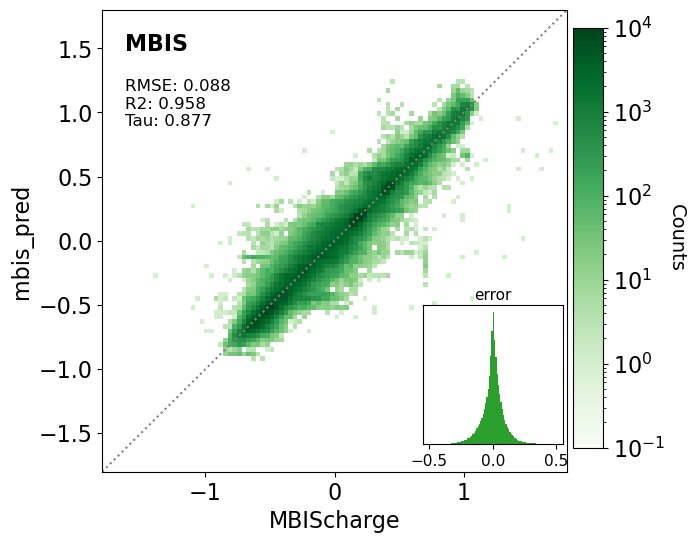

In [28]:
dash_corr_plot(df, "MBIScharge", "mbis_pred", fig=plt.figure(figsize=(6,6)), ax=plt.gca(), xy_range=(-1.8,1.8), text="MBIS", vmin=0.1, vmax=10000, stats=True)

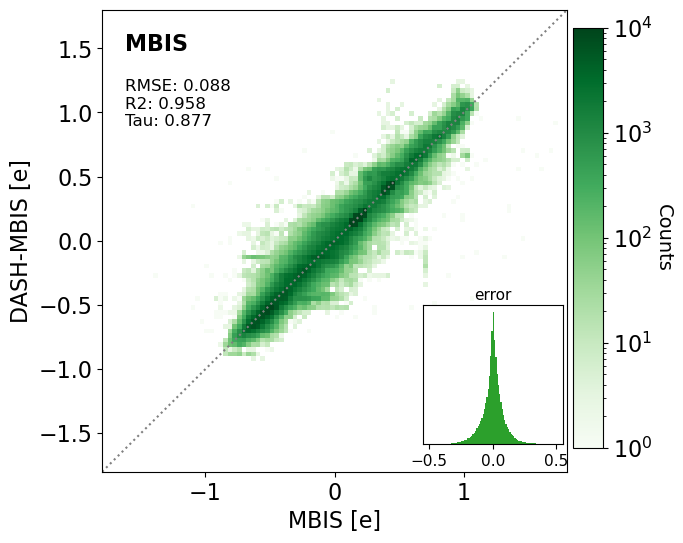

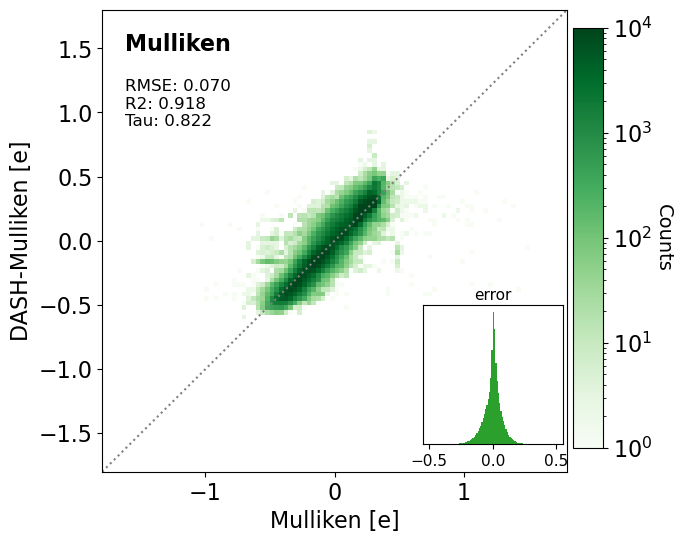

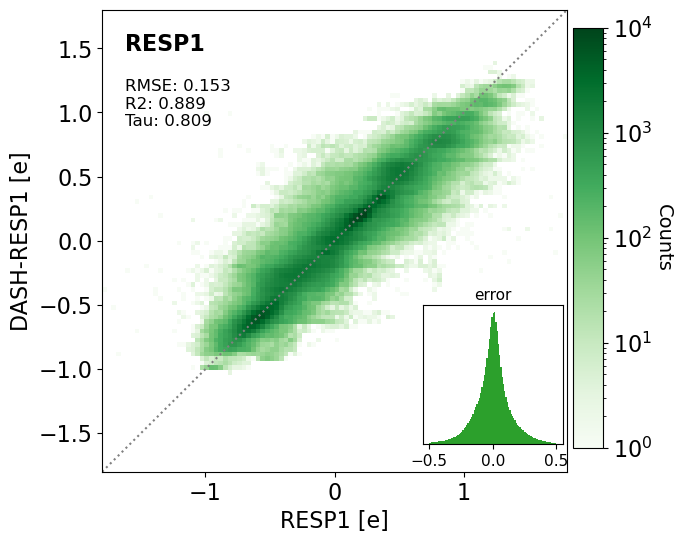

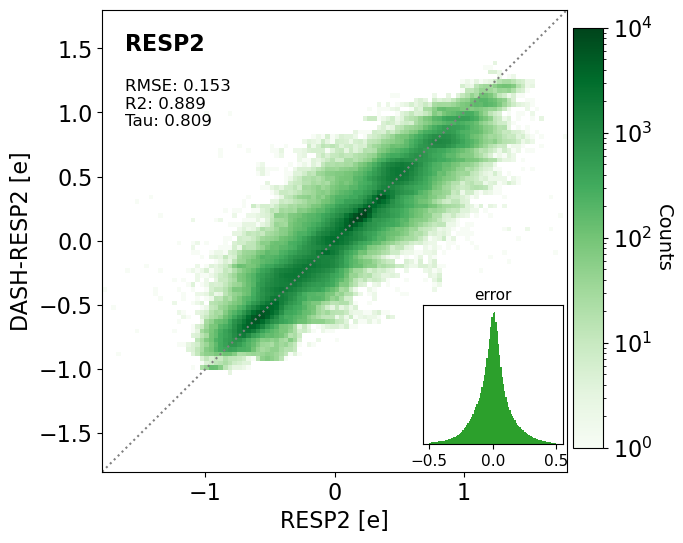

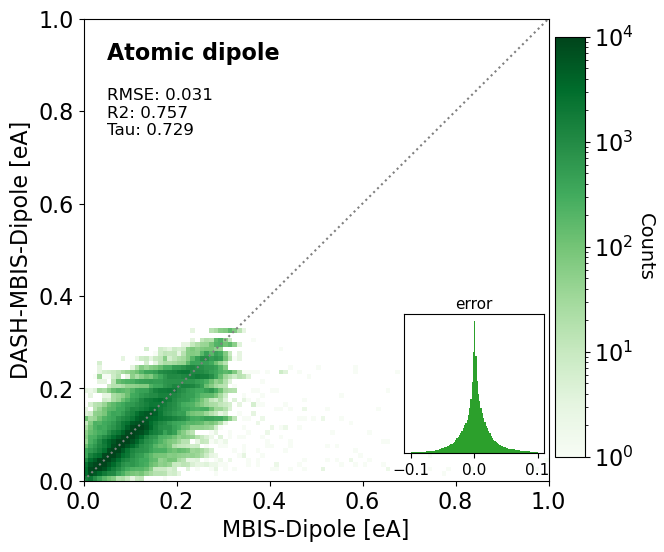

In [29]:
for x, y, text, xy_range, xlabel, ylabel, err_range in prop_plto_args:
    fig, ax = plt.subplots(figsize=(6,6))
    dash_corr_plot(df=df, x=x, y=y, fig=fig, ax=ax, xy_range=xy_range, xlabel=xlabel, 
                   ylabel=ylabel, vmin=1, vmax=10000, text=text, err_range=err_range, stats=True)
    fig.savefig(f"test_301_vehicle_{text}.pdf", bbox_inches="tight")

In [30]:
debye_to_ea = 0.393430307
debye_to_eA = 0.20819434

In [55]:
df_mol["ref_dipole_debye"] = df_mol["ref_dipole"] #* debye_to_ea
df_mol["mol_dipole_no_atomic_debye"] = df_mol["mol_dipole_no_atomic"] * debye_to_ea#* debye_to_eA/debye_to_ea
df_mol["mol_dipole_with_atomic_debye"] = df_mol["mol_dipole_with_atomic"] * debye_to_ea#* debye_to_eA/debye_to_ea

In [56]:
df_mol

,Unnamed: 0,mol_dipole_no_atomic,mol_dipole_with_atomic,ref_dipole,ref_dipole_debye,mol_dipole_no_atomic_debye,mol_dipole_with_atomic_debye
0,0,2.517692,2.638069,1.201601,1.201601,0.990536,1.037896
1,1,2.517422,2.637725,1.201616,1.201616,0.990430,1.037761
2,2,2.517585,2.637906,1.201599,1.201599,0.990494,1.037832
3,3,3.050717,2.695111,0.785519,0.785519,1.200244,1.060339
4,4,3.051729,2.695845,0.785729,0.785729,1.200643,1.060627
...,...,...,...,...,...,...,...
73386,73386,1.728530,2.713484,0.584582,0.584582,0.680056,1.067567
73387,73387,1.730233,2.714937,0.583813,0.583813,0.680726,1.068138
73388,73388,4.240327,3.940248,1.848550,1.848550,1.668273,1.550213
73389,73389,4.239697,3.941084,1.855903,1.855903,1.668025,1.550542


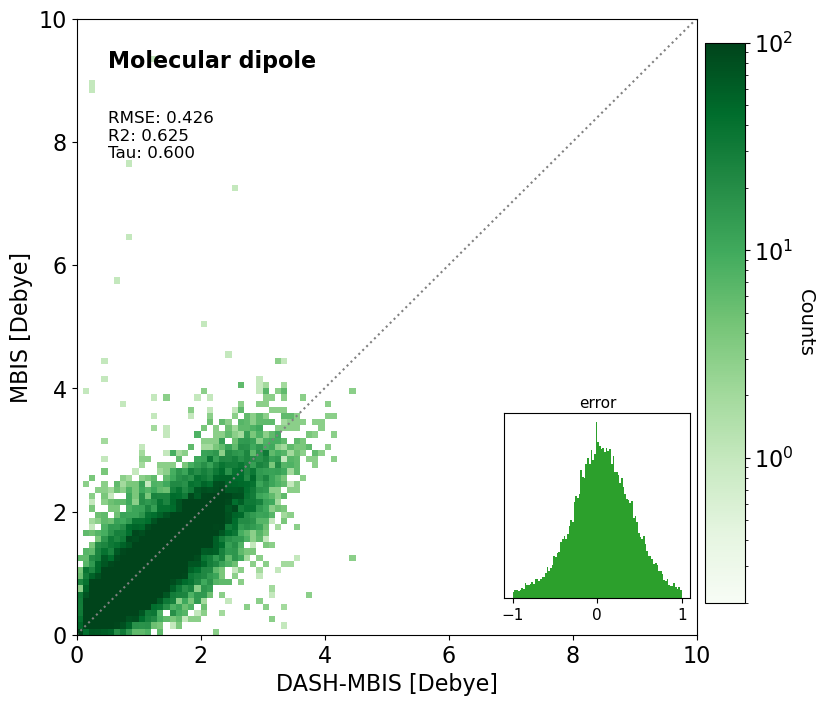

In [57]:
fig, ax = plt.subplots(figsize=(8,8))
dash_corr_plot(df=df_mol, x="mol_dipole_no_atomic_debye", y="ref_dipole_debye", fig=fig, ax=ax, xy_range=(0,10), xlabel="DASH-MBIS [Debye]", 
               ylabel="MBIS [Debye]", vmin=0.2, vmax=100, text="Molecular dipole", err_range=(-1,1), stats=True)
fig.savefig(f"test_301_vehicle_mol_dipole_noAtomDipole.pdf", bbox_inches="tight")

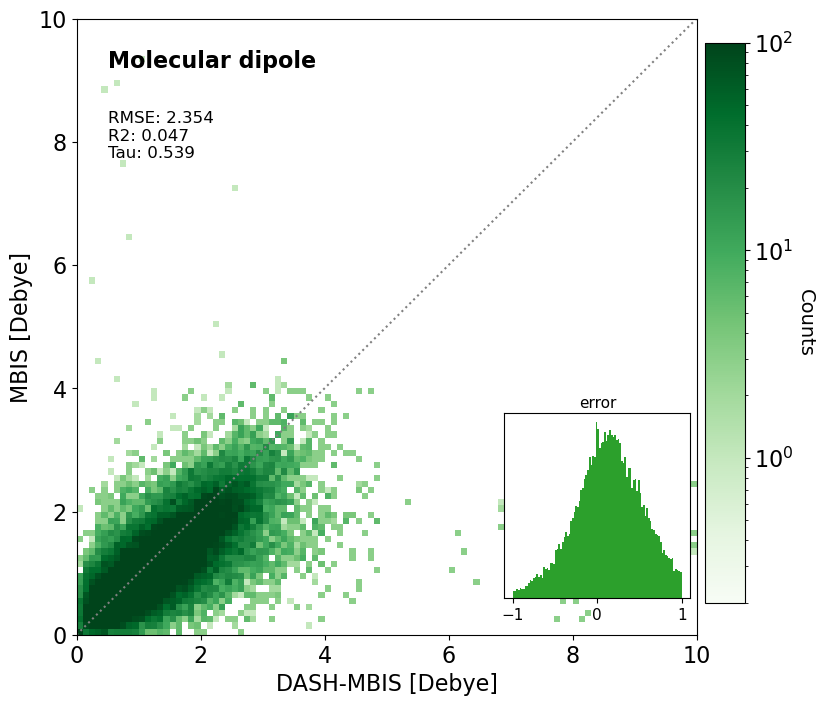

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
dash_corr_plot(df=df_mol, x="mol_dipole_with_atomic_debye", y="ref_dipole_debye", fig=fig, ax=ax, xy_range=(0,10), xlabel="DASH-MBIS [Debye]", 
               ylabel="MBIS [Debye]", vmin=0.2, vmax=100, text="Molecular dipole", err_range=(-1,1), stats=True)
fig.savefig(f"test_301_vehicle_mol_dipole_withAtomDipole.pdf", bbox_inches="tight")

In [35]:
charges_folder = "/localhome/mlehner/props/test190_vehicle/test176_vehicle/charges/"

In [36]:
df_list = []
for file in tqdm(glob.glob(charges_folder + "*.csv")):
    df_list.append(pd.read_csv(file))
am1bcc_df = pd.concat(df_list, ignore_index=True)

100%|██████████| 250/250 [00:00<00:00, 704.23it/s]


In [37]:
vehicle_sdf_176 = Chem.SDMolSupplier("/localhome/mlehner/props/test190_vehicle/test176_vehicle/combined.sdf", removeHs=False)

In [38]:
tree.data_storage[0].keys()

Index(['level', 'atom_type', 'con_atom', 'con_type', 'result', 'std',
       'max_attention', 'size', 'mulliken', 'resp1', 'resp2', 'dual',
       'mbis_dipole_strength', 'dipole_bond_1', 'dipole_bond_2',
       'dipole_bond_3', 'AM1BCC', 'AM1BCC_std', 'DFTD4:C6', 'DFTD4:C6_std',
       'DFTD4:polarizability', 'DFTD4:polarizability_std'],
      dtype='object')

In [39]:
df_am1bcc_mol_atom_dict = {}
for idx, row in tqdm(am1bcc_df.iterrows(), total=len(am1bcc_df)):
    mol_idx = row["mol_index"]
    atom_idx = row["atom_index"]
    if mol_idx not in df_am1bcc_mol_atom_dict:
        df_am1bcc_mol_atom_dict[mol_idx] = {}
    df_am1bcc_mol_atom_dict[mol_idx][atom_idx] = row["am1Bcc"]

100%|██████████| 341783/341783 [00:14<00:00, 23394.00it/s]


In [40]:
data_dash_176 = []
for mol_index, mol in tqdm(enumerate(vehicle_sdf_176), total=len(vehicle_sdf_176)):
    mol_idx = [mol_index]*mol.GetNumAtoms()
    atom_idx = list(range(mol.GetNumAtoms()))
    nodePathList = nodePathList = tree._get_allAtoms_nodePaths(mol=mol)
    dash_am1bcc = tree.get_molecules_partial_charges(mol, chg_key="AM1BCC", chg_std_key="AM1BCC_std", nodePathList=nodePathList)["charges"]
    ref_dash = []
    for atom_idx in range(mol.GetNumAtoms()):
        ref_dash.append(df_am1bcc_mol_atom_dict[mol_index][atom_idx])
    mini_df = pd.DataFrame({"mol_index": mol_idx, "atom_index": atom_idx, "dash_am1bcc": dash_am1bcc, "ref_dash": ref_dash})
    data_dash_176.append(mini_df)

df_dash_176 = pd.concat(data_dash_176, ignore_index=True)    

100%|██████████| 24657/24657 [01:36<00:00, 255.26it/s]


In [41]:
df_dash_176

,mol_index,atom_index,dash_am1bcc,ref_dash
0,0,11,0.031773,0.31012
1,0,11,-0.236500,-0.23968
2,0,11,0.019332,-0.18398
3,0,11,-0.233540,-0.18268
4,0,11,0.243660,0.23452
...,...,...,...,...
341778,24656,15,-0.450897,-0.44898
341779,24656,15,0.127666,0.16713
341780,24656,15,0.324555,0.31082
341781,24656,15,0.069465,0.06723


In [42]:
# filter out 0 values
df_dash_176_filtered = df_dash_176[(df_dash_176["ref_dash"] != 0)]

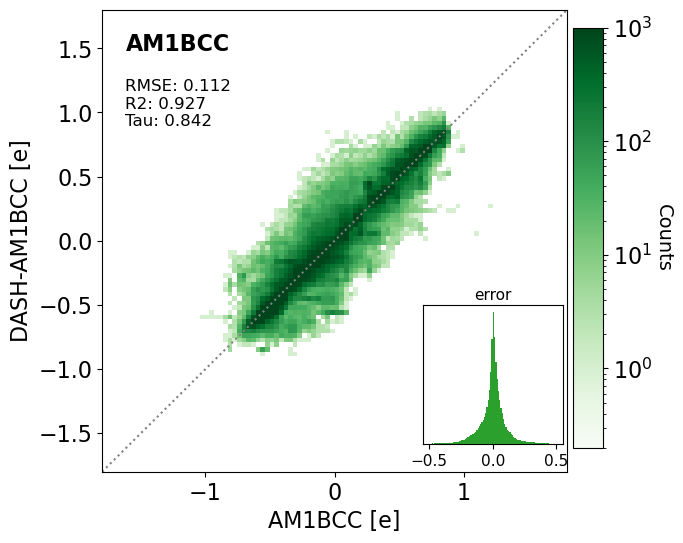

In [43]:
# correlation plot with am1Bcc vs tree charges
fig, ax = plt.subplots(figsize=(6,6))
dash_corr_plot(df=df_dash_176_filtered, x="ref_dash", y="dash_am1bcc", fig=fig, ax=ax, xy_range=(-1.8,1.8), xlabel="AM1BCC [e]", 
               ylabel="DASH-AM1BCC [e]", vmin=0.2, vmax=1000, text="AM1BCC", err_range=(-0.5,0.5), stats=True)
fig.savefig(f"test_301_vehicle_176_am1bcc.pdf", bbox_inches="tight")

In [44]:
tree.data_storage[0].keys()

Index(['level', 'atom_type', 'con_atom', 'con_type', 'result', 'std',
       'max_attention', 'size', 'mulliken', 'resp1', 'resp2', 'dual',
       'mbis_dipole_strength', 'dipole_bond_1', 'dipole_bond_2',
       'dipole_bond_3', 'AM1BCC', 'AM1BCC_std', 'DFTD4:C6', 'DFTD4:C6_std',
       'DFTD4:polarizability', 'DFTD4:polarizability_std'],
      dtype='object')

In [45]:
import dftd4
from dftd4 import interface

In [46]:
damp_params = interface.DampingParam(method="tpssh")

In [47]:
c6_storage = []
for mol in tqdm(vehicle_sdf_176, total=len(vehicle_sdf_176)):
    atom_numbers = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])
    atom_positions = mol.GetConformer().GetPositions()
    atom_positions_bohr = atom_positions * 1.88973
    model = interface.DispersionModel(atom_numbers, atom_positions_bohr)
    res = model.get_dispersion(damp_params, grad=False)
    res.update(**model.get_properties())
    c6_coef = res.get("c6 coefficients")
    c6_coef_diag = np.diag(c6_coef)
    polarizability = res.get("polarizibilities")
    dash_c6 = []
    dash_pol = []
    nodePathList = tree._get_allAtoms_nodePaths(mol=mol)
    for atom_idx in range(mol.GetNumAtoms()):
        nodePath = nodePathList[atom_idx]
        dash_c6.append(tree.get_property_noNAN(matched_node_path=nodePath, property_name="DFTD4:C6"))
        dash_pol.append(tree.get_property_noNAN(matched_node_path=nodePath, property_name="DFTD4:polarizability"))
    mini_df = pd.DataFrame({"c6": dash_c6, "pol": dash_pol, "c6_diag": c6_coef_diag, "polarizability": polarizability})
    c6_storage.append(mini_df)
df_c6 = pd.concat(c6_storage, ignore_index=True)

100%|██████████| 24657/24657 [05:10<00:00, 79.38it/s]


In [48]:
df_c6

,c6,pol,c6_diag,polarizability
0,28.0970,8.6612,27.526789,8.518339
1,29.5714,8.8925,29.464604,8.876631
2,26.6139,7.7242,26.043727,7.641360
3,29.0089,8.7999,29.558461,8.889340
4,29.4394,8.8706,28.719891,8.760659
...,...,...,...,...
341778,21.0287,6.1533,19.330754,5.899568
341779,1.5087,1.9208,1.337797,1.808725
341780,0.8848,1.4735,0.862320,1.454658
341781,1.5605,1.9535,1.408886,1.856149


In [60]:
df_c6["c6_diag"].max()

142.23743635056545

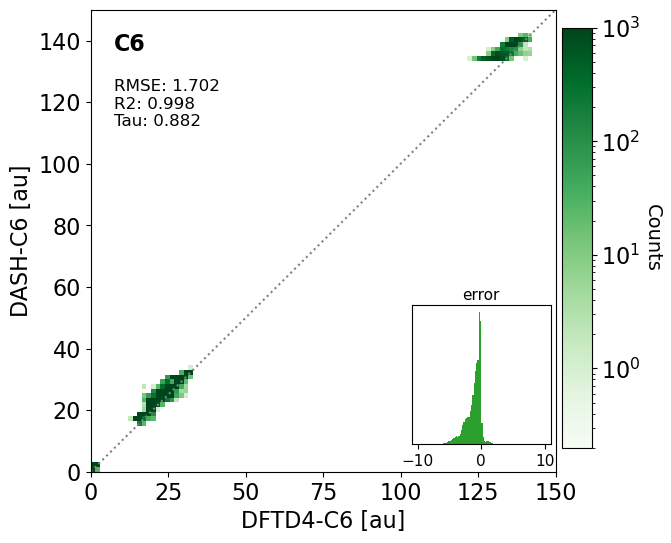

In [61]:
fig, ax = plt.subplots(figsize=(6,6))
dash_corr_plot(df=df_c6, x="c6_diag", y="c6", fig=fig, ax=ax, xy_range=(0,150), xlabel="DFTD4-C6 [au]", 
               ylabel="DASH-C6 [au]", vmin=0.2, vmax=1000, text="C6", err_range=(-10,10), stats=True)
fig.savefig("test_301_vehicle_176_c6.pdf", bbox_inches="tight")

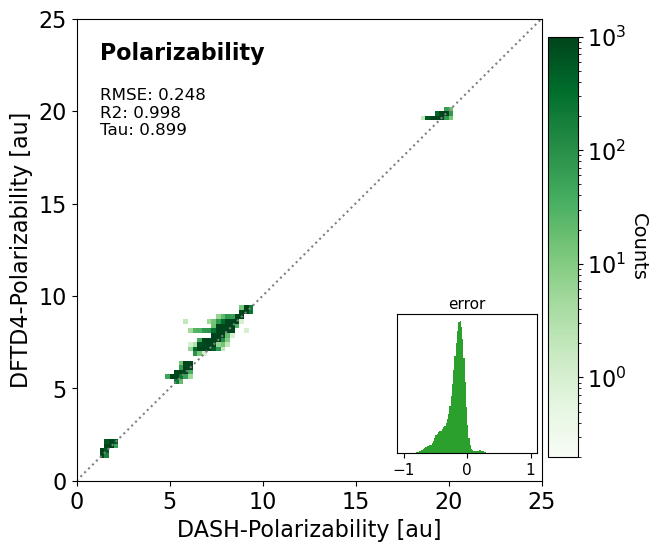

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
dash_corr_plot(df=df_c6, x="polarizability", y="pol", fig=fig, ax=ax, xy_range=(0,25), xlabel="DASH-Polarizability [au]", 
               ylabel="DFTD4-Polarizability [au]", vmin=0.2, vmax=1000, text="Polarizability", err_range=(-1,1), stats=True)
fig.savefig("test_301_vehicle_176_pol.pdf", bbox_inches="tight")

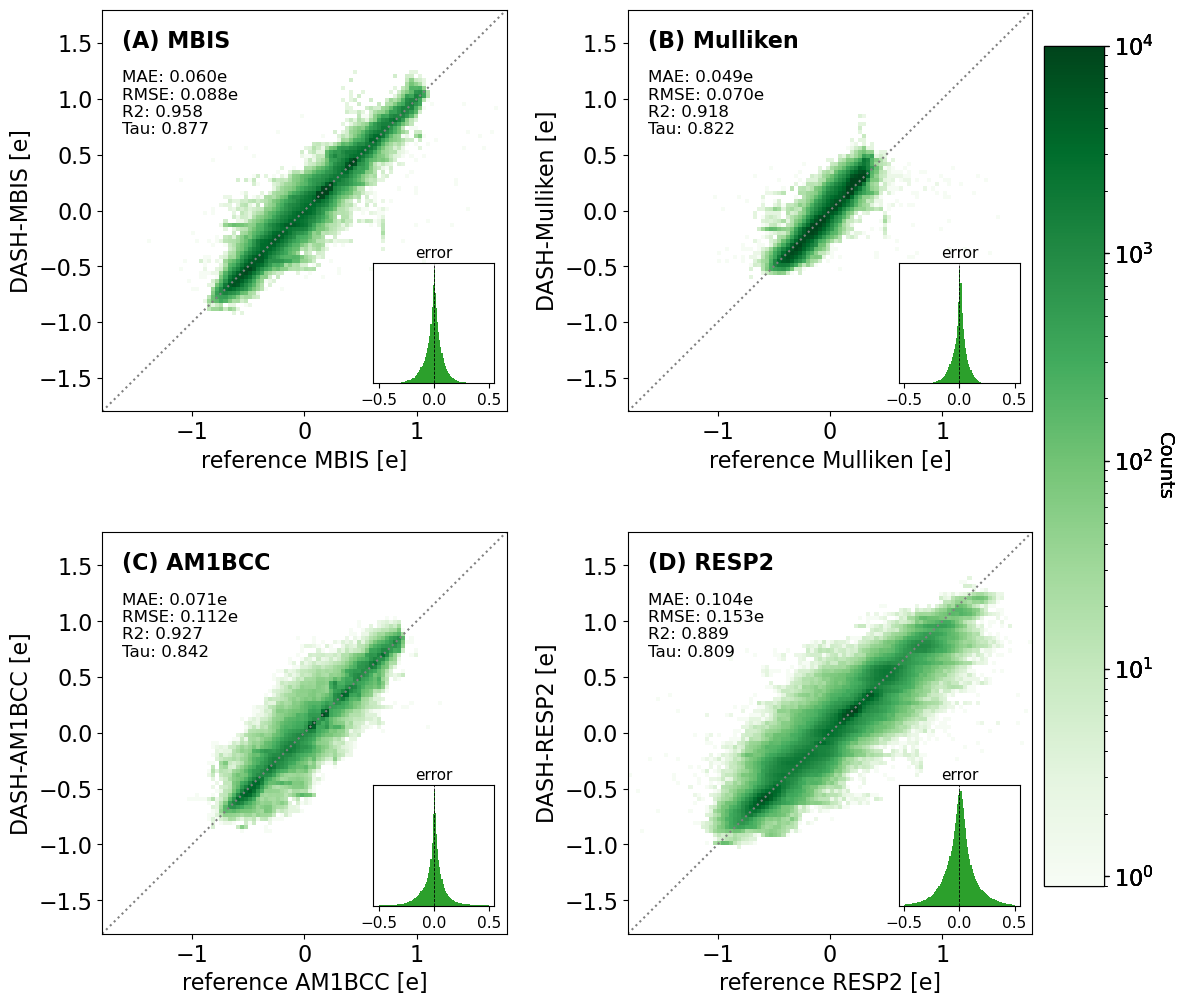

In [97]:
# all charges
xy_range = (-1.8,1.8)
vmin = 0.9
vmax = 10000
err_range = (-0.5,0.5)
insert_loc = [0.67 , 0.07, 0.3, 0.3]
insert_yticks = []#[1e5]
fig, ax = plt.subplots(2,2, figsize=(12,12))
dash_corr_plot(df=df, x="MBIScharge", y="mbis_pred", fig=fig, ax=ax[0,0], xy_range=xy_range, xlabel="reference MBIS [e]", ylabel="DASH-MBIS [e]", vmin=vmin, vmax=vmax, text="(A) MBIS", err_range=err_range, stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="e")
dash_corr_plot(df=df, x="mulliken", y="mulliken_pred", fig=fig, ax=ax[0,1], xy_range=xy_range, xlabel="reference Mulliken [e]", ylabel="DASH-Mulliken [e]", vmin=vmin, vmax=vmax, text="(B) Mulliken", err_range=err_range, stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="e")
dash_corr_plot(df=df, x="resp2", y="resp2_pred", fig=fig, ax=ax[1,1], xy_range=xy_range, xlabel="reference RESP2 [e]", ylabel="DASH-RESP2 [e]", vmin=vmin, vmax=vmax, text="(D) RESP2", err_range=err_range, stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="e")
dash_corr_plot(df=df_dash_176_filtered, x="ref_dash", y="dash_am1bcc", fig=fig, ax=ax[1,0], xy_range=xy_range, xlabel="reference AM1BCC [e]", ylabel="DASH-AM1BCC [e]", vmin=vmin, vmax=vmax, text="(C) AM1BCC", err_range=err_range, stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="e")
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig("test_301_SI_vehicle_all_charges.pdf", bbox_inches="tight")

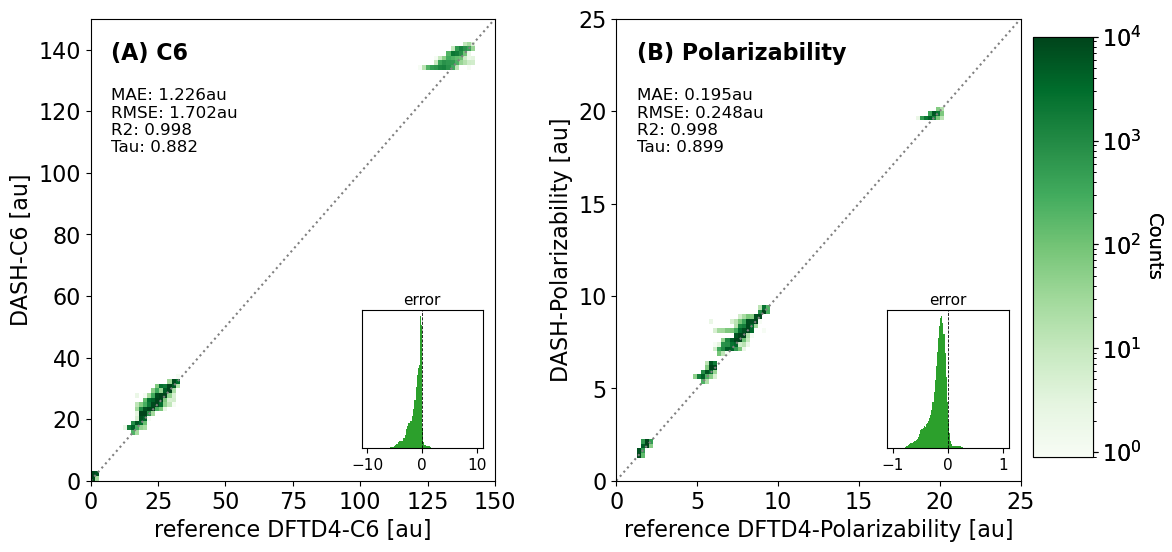

In [98]:
# C6 and polarizability
xy_range = (0,150)
vmin = 0.9
vmax = 10000
err_range = (-10,10)
insert_loc = [0.67 , 0.07, 0.3, 0.3]
insert_yticks = []#[1e5]
fig, ax = plt.subplots(1,2, figsize=(12,6))
dash_corr_plot(df=df_c6, x="c6_diag", y="c6", fig=fig, ax=ax[0], xy_range=xy_range, xlabel="reference DFTD4-C6 [au]", ylabel="DASH-C6 [au]", vmin=vmin, vmax=vmax, text="(A) C6", err_range=err_range, stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="au")
dash_corr_plot(df=df_c6, x="polarizability", y="pol", fig=fig, ax=ax[1], xy_range=(0,25), xlabel="reference DFTD4-Polarizability [au]", ylabel="DASH-Polarizability [au]", vmin=vmin, vmax=vmax, text="(B) Polarizability", err_range=(-1,1), stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="au")
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig("test_301_SI_vehicle_c6_pol.pdf", bbox_inches="tight")

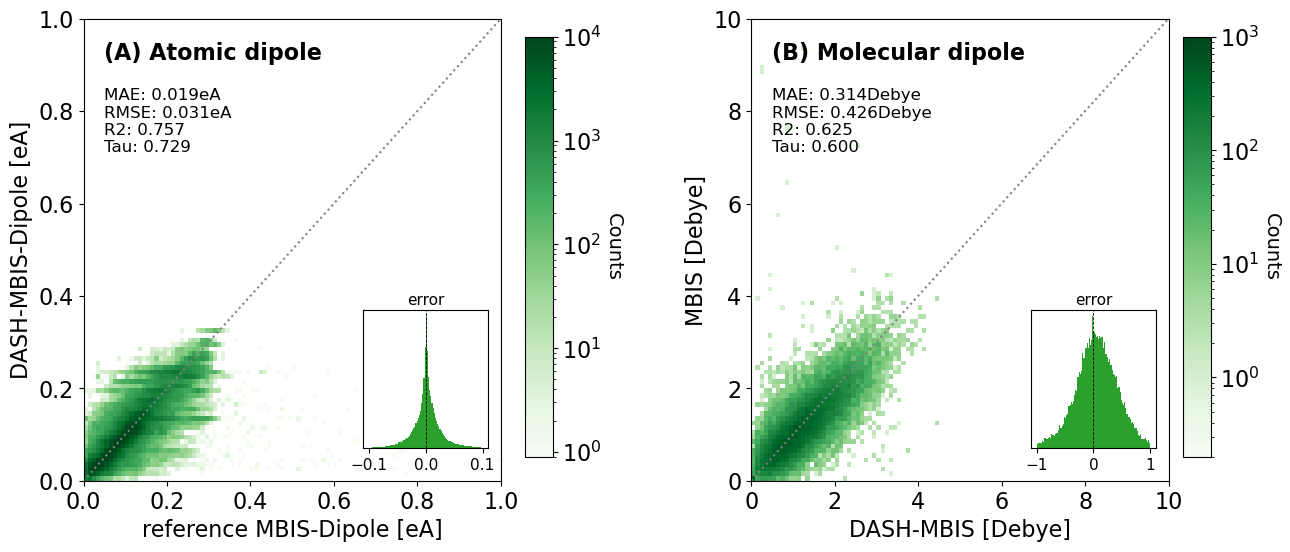

In [99]:
# atomic and molecular dipole
xy_range = (0,1)
vmin = 0.9
vmax = 10000
err_range = (-0.1,0.1)
insert_loc = [0.67 , 0.07, 0.3, 0.3]
insert_yticks = []#[1e5]
fig, ax = plt.subplots(1,2, figsize=(14,6))
dash_corr_plot(df=df, x="mbis_dipole_strength", y="mbis_dipole_strength_pred", fig=fig, ax=ax[0], xy_range=xy_range, xlabel="reference MBIS-Dipole [eA]", ylabel="DASH-MBIS-Dipole [eA]", vmin=vmin, vmax=vmax, text="(A) Atomic dipole", err_range=err_range, stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="eA", cbar_ax_loc=[0.44, 0.15, 0.02, 0.7])

dash_corr_plot(df=df_mol, x="mol_dipole_no_atomic_debye", y="ref_dipole_debye", fig=fig, ax=ax[1], xy_range=(0,10), xlabel="DASH-MBIS [Debye]", ylabel="MBIS [Debye]", vmin=0.2, vmax=1000, text="(B) Molecular dipole", err_range=(-1,1), stats=True, inset_loc=insert_loc, draw_inset_0_vline=True, insert_yticks=insert_yticks, unit_stats="Debye", cbar_ax_loc=[0.91, 0.15, 0.02, 0.7])
fig.subplots_adjust(hspace=0.3, wspace=0.6)
fig.savefig("test_301_SI_vehicle_dipole.pdf", bbox_inches="tight")